## Домашнее задание 4 - 10 баллов

В этом задании вам предстоит дообучить трансформерную модель для NER-задачи в различных форматах:

1. Обучите NER-модель

- Загрузите набор данных [Collection5](https://github.com/natasha/corus?tab=readme-ov-file#load_ne5) - **1 балл**
- Разбейте набор данных на train/test части
- Дообучите модель [rubert-tiny2](https://huggingface.co/cointegrated/rubert-tiny2) на train-части корпуса для решения NER-задачи, сделайте замеры качества NER-метрик до и после дообучения - **2 балла**

2. Попробуйте улучшить качество модели следующими способами:
- Предварительно дообучите на train-части в MLM режиме, а потом дообучите на NER-задачу - **2 балла**
- Сгенерируйте синтетическую разметку* подходящего**, на ваш взгляд, новостного корпуса большой и умной моделью для русскоязычного NER***, а затем использовав ее для дообучения rubert-tiny2 вместе с основным набором данных - **2 балла**

3. Финально сравните результаты различных подходов - **1 балл**

*прогоните датасет через NER-модель, получите ее предсказания и используйте их в качестве резметки

**Можно использовать уже знакомый вам датасет lenta-ru, объем данных лучше взять от 10_000 текстов

***Например, можно взять модель модель DeepPavlov ner_collection3_bert. Инструкция по запуску есть в [документации](https://docs.deeppavlov.ai/en/master/features/models/NER.html)

**Общее**

- Принимаемые решения обоснованы (почему выбрана определенная архитектура/гиперпараметр/оптимизатор/преобразование и т.п.) - **1 балл**
- Обеспечена воспроизводимость решения: зафиксированы random_state, ноутбук воспроизводится от начала до конца без ошибок - **1 балл**

**Формат сдачи ДЗ**

- Каждая домашняя работа – PR в отдельную ветку **hw_n**, где **n** - номер домашней работы
- Добавить ментора и pacifikus в reviewers
- Дождаться ревью, если все ок – мержим в main
- Если не ок – вносим исправления и снова отправляем на ревью

In [100]:
import pandas as pd
import numpy as np

from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
    DataCollatorForLanguageModeling,
    AutoModelForMaskedLM,
)
import evaluate
from razdel import tokenize
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

from collections import Counter, defaultdict

from corus import load_ne5, load_lenta

import seaborn as sns
import matplotlib.pyplot as plt

### 1. Обучение NER модели

In [ ]:
DATA_PATH = "./data/ner/Collection5/"

In [ ]:
corpus = list(load_ne5(DATA_PATH))
corpus[0]

Ne5Markup(
    id='001',
    text='Россия рассчитывает на конструктивное воздействие США на Грузию\r\n\r\n04/08/2008 12:08\r\n\r\nМОСКВА, 4 авг - РИА Новости. Россия рассчитывает, что США воздействуют на Тбилиси в связи с обострением ситуации в зоне грузино-осетинского конфликта. Об этом статс-секретарь - заместитель министра иностранных дел России Григорий Карасин заявил в телефонном разговоре с заместителем госсекретаря США Дэниэлом Фридом.\r\n\r\n"С российской стороны выражена глубокая озабоченность в связи с новым витком напряженности вокруг Южной Осетии, противозаконными действиями грузинской стороны по наращиванию своих вооруженных сил в регионе, бесконтрольным строительством фортификационных сооружений", - говорится в сообщении.\r\n\r\n"Россия уже призвала Тбилиси к ответственной линии и рассчитывает также на конструктивное воздействие со стороны Вашингтона", - сообщил МИД России. ',
    spans=[Ne5Span(
         index='T1',
         type='GEOPOLIT',
         start=0,
         st

In [ ]:
type2text = defaultdict(Counter)
ents = Counter()
for item in corpus:
    for e in item.spans:
        ents[e.type] += 1
        type2text[e.type][e.text] += 1

for k, v in ents.most_common():
    print(k, v)
    print(type2text[k].most_common(3))

PER 10623
[('Дмитрий Медведев', 159), ('Д.Медведев', 116), ('Владимир Путин', 80)]
ORG 7033
[('МВД', 321), ('Единой России', 111), ('Госдумы', 98)]
GEOPOLIT 4104
[('РФ', 734), ('России', 483), ('США', 423)]
LOC 3140
[('Москвы', 224), ('Московской области', 102), ('Москве', 86)]
MEDIA 1509
[('РИА Новости', 180), ('СМИ', 155), ('ИА REGNUM', 128)]


In [37]:
def extract_labels(item):
    raw_toks = list(tokenize(item.text))
    words = [tok.text for tok in raw_toks]
    word_labels = ["O"] * len(raw_toks)
    char2word = [None] * len(item.text)
    for i, word in enumerate(raw_toks):
        char2word[word.start : word.stop] = [i] * len(word.text)

    for e in item.spans:
        e_words = sorted({idx for idx in char2word[e.start : e.stop] if idx is not None})
        word_labels[e_words[0]] = "B-" + e.type
        for idx in e_words[1:]:
            word_labels[idx] = "I-" + e.type

    return {"tokens": words, "tags": word_labels}

In [ ]:
print(extract_labels(corpus[0]))

{'tokens': ['Россия', 'рассчитывает', 'на', 'конструктивное', 'воздействие', 'США', 'на', 'Грузию', '04/08/2008', '12', ':', '08', 'МОСКВА', ',', '4', 'авг', '-', 'РИА', 'Новости', '.', 'Россия', 'рассчитывает', ',', 'что', 'США', 'воздействуют', 'на', 'Тбилиси', 'в', 'связи', 'с', 'обострением', 'ситуации', 'в', 'зоне', 'грузино-осетинского', 'конфликта', '.', 'Об', 'этом', 'статс-секретарь', '-', 'заместитель', 'министра', 'иностранных', 'дел', 'России', 'Григорий', 'Карасин', 'заявил', 'в', 'телефонном', 'разговоре', 'с', 'заместителем', 'госсекретаря', 'США', 'Дэниэлом', 'Фридом', '.', '"', 'С', 'российской', 'стороны', 'выражена', 'глубокая', 'озабоченность', 'в', 'связи', 'с', 'новым', 'витком', 'напряженности', 'вокруг', 'Южной', 'Осетии', ',', 'противозаконными', 'действиями', 'грузинской', 'стороны', 'по', 'наращиванию', 'своих', 'вооруженных', 'сил', 'в', 'регионе', ',', 'бесконтрольным', 'строительством', 'фортификационных', 'сооружений', '"', ',', '-', 'говорится', 'в', 'со

In [ ]:
ner_data = [extract_labels(item) for item in corpus]
ner_train, ner_test = train_test_split(ner_data, test_size=0.2, random_state=42)

In [44]:
label_list = sorted({label for item in ner_train for label in item["tags"]})
if "O" in label_list:
    label_list.remove("O")
    label_list = ["O"] + label_list
label_list

['O',
 'B-GEOPOLIT',
 'B-LOC',
 'B-MEDIA',
 'B-ORG',
 'B-PER',
 'I-GEOPOLIT',
 'I-LOC',
 'I-MEDIA',
 'I-ORG',
 'I-PER']

In [ ]:
ner_data = DatasetDict(
    {"train": Dataset.from_pandas(pd.DataFrame(ner_train)), "test": Dataset.from_pandas(pd.DataFrame(ner_test))}
)
ner_data

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 800
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 200
    })
})

In [ ]:
MODEL_NAME = "cointegrated/rubert-tiny"

In [28]:
ner_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [45]:
def tokenize_and_align_labels(examples, label_all_tokens=True):
    tokenized_inputs = ner_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples["tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        label_ids = [label_list.index(idx) if isinstance(idx, str) else idx for idx in label_ids]

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [30]:
tokenized_ner_datasets = ner_data.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [31]:
ner_model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME, num_labels=len(label_list))
ner_model.config.id2label = dict(enumerate(label_list))
ner_model.config.label2id = {v: k for k, v in ner_model.config.id2label.items()}

Some weights of BertForTokenClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
ner_data_collator = DataCollatorForTokenClassification(ner_tokenizer)

In [46]:
seqeval = evaluate.load("seqeval")


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels, zero_division=0)
    return results

In [34]:
batch_size = 32

# больщинство аргументов с пары, не вижу смысла их обосновывать
ner_args = TrainingArguments(
    output_dir="ner",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    run_name="ner",
    logging_steps=1,
)

ner_trainer = Trainer(
    model=ner_model,
    args=ner_args,
    train_dataset=tokenized_ner_datasets["train"],
    eval_dataset=tokenized_ner_datasets["test"],
    processing_class=ner_tokenizer,
    data_collator=ner_data_collator,
    compute_metrics=compute_metrics,
)

In [47]:
def get_pretty_metrics(data):
    # Отдельные таблицы
    train_entities = {
        k.split("_")[-1]: v for k, v in data.items() if k.startswith("eval_train_") and isinstance(v, dict)
    }
    test_entities = {k.split("_")[-1]: v for k, v in data.items() if k.startswith("eval_test_") and isinstance(v, dict)}

    train_df = pd.DataFrame(train_entities).T
    test_df = pd.DataFrame(test_entities).T

    # Таблица общих метрик
    train_overall = {
        k.replace("eval_train_", ""): v
        for k, v in data.items()
        if k.startswith("eval_train_") and not isinstance(v, dict)
    }
    test_overall = {
        k.replace("eval_test_", ""): v
        for k, v in data.items()
        if k.startswith("eval_test_") and not isinstance(v, dict)
    }

    overall_df = pd.DataFrame([train_overall, test_overall], index=["Train", "Test"]).T

    # Вывод
    print("\n=== Метрики по сущностям (Train) ===")
    print(train_df.round(4))

    print("\n=== Метрики по сущностям (Test) ===")
    print(test_df.round(4))

    print("\n=== Общие метрики ===")
    print(overall_df.round(4))

In [49]:
results_before_train = ner_trainer.evaluate(
    eval_dataset={"train": tokenized_ner_datasets["train"], "test": tokenized_ner_datasets["test"]}
)
get_pretty_metrics(results_before_train)


=== Метрики по сущностям (Train) ===
          precision  recall      f1   number
GEOPOLIT     0.0079  0.0338  0.0128   4736.0
LOC          0.0105  0.0713  0.0182   6440.0
MEDIA        0.0034  0.0602  0.0065   2708.0
ORG          0.0472  0.2346  0.0786  13890.0
PER          0.0348  0.1832  0.0585  15204.0

=== Метрики по сущностям (Test) ===
          precision  recall      f1  number
GEOPOLIT     0.0062  0.0279  0.0101  1111.0
LOC          0.0099  0.0738  0.0175  1436.0
MEDIA        0.0034  0.0571  0.0064   718.0
ORG          0.0478  0.2255  0.0789  3548.0
PER          0.0361  0.1940  0.0609  3871.0

=== Общие метрики ===
                          Train     Test
loss                     2.5079   2.5070
model_preparation_time   0.0000   0.0000
overall_precision        0.0262   0.0265
overall_recall           0.1588   0.1618
overall_f1               0.0450   0.0455
overall_accuracy         0.0673   0.0673
runtime                  8.4738   2.1827
samples_per_second      94.4090  91.6290

In [ ]:
ner_trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Geopolit,Loc,Media,Org,Per,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,1.582400,1.500488,0.000700,"{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 3548}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 3871}",0.000000,0.000000,0.000000,0.759441
2,1.118800,1.012015,0.000700,"{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 3548}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 3871}",0.000000,0.000000,0.000000,0.759621
3,0.849000,0.844265,0.000700,"{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 3548}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 3871}",0.000000,0.000000,0.000000,0.759686
4,0.743800,0.732967,0.000700,"{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 3548}","{'precision': 0.1348314606741573, 'recall': 0.14879876001033324, 'f1': 0.1414712022596095, 'number': 3871}",0.134831,0.053912,0.077026,0.796301
5,0.607300,0.687297,0.000700,"{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.20512820512820512, 'recall': 0.004509582863585118, 'f1': 0.00882515168229454, 'number': 3548}","{'precision': 0.14482010486349667, 'recall': 0.20692327563936966, 'f1': 0.1703892788768347, 'number': 3871}",0.145659,0.076469,0.100288,0.802745
6,0.673200,0.662424,0.000700,"{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.37583892617449666, 'recall': 0.03156708004509583, 'f1': 0.058242329693187725, 'number': 3548}","{'precision': 0.13842281879194632, 'recall': 0.21312322397313355, 'f1': 0.1678364357644187, 'number': 3871}",0.149728,0.087701,0.110613,0.805658
7,0.696100,0.638624,0.000700,"{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.3873056994818653, 'recall': 0.0842728297632469, 'f1': 0.13842592592592595, 'number': 3548}","{'precision': 0.13903471634208298, 'recall': 0.21208989925083957, 'f1': 0.16796235679214402, 'number': 3871}",0.167740,0.104830,0.129025,0.812141
8,0.588300,0.623016,0.000700,"{'precision': 0.8, 'recall': 0.0072007200720072, 'f1': 0.014272970561998215, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.401536312849162, 'recall': 0.1620631341600902, 'f1': 0.23092369477911648, 'number': 3548}","{'precision': 0.1383399209486166, 'recall': 0.20795660036166366, 'f1': 0.16615067079463366, 'number': 3871}",0.191158,0.129914,0.154695,0.815994
9,0.656800,0.601187,0.000700,"{'precision': 0.7678571428571429, 'recall': 0.0387038703870387, 'f1': 0.07369323050556983, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.4044554455445545, 'recall': 0.2302705749718151, 'f1': 0.2934626436781609, 'number': 3

TrainOutput(global_step=500, training_loss=0.7400375214219094, metrics={'train_runtime': 138.2674, 'train_samples_per_second': 115.718, 'train_steps_per_second': 3.616, 'total_flos': 113325785088000.0, 'train_loss': 0.7400375214219094, 'epoch': 20.0})

In [ ]:
# очевидно, метрики после обучения заметно выросли
results_after_train = ner_trainer.evaluate(
    eval_dataset={"train": tokenized_ner_datasets["train"], "test": tokenized_ner_datasets["test"]}
)
get_pretty_metrics(results_after_train)


=== Метрики по сущностям (Train) ===
          precision  recall      f1   number
GEOPOLIT     0.7568  0.3784  0.5045   4736.0
LOC          0.3930  0.0157  0.0302   6440.0
MEDIA        0.0781  0.0018  0.0036   2708.0
ORG          0.3908  0.4519  0.4192  13890.0
PER          0.2067  0.2449  0.2242  15204.0

=== Метрики по сущностям (Test) ===
          precision  recall      f1  number
GEOPOLIT     0.7111  0.3699  0.4867  1111.0
LOC          0.4259  0.0160  0.0309  1436.0
MEDIA        0.1000  0.0014  0.0027   718.0
ORG          0.4036  0.4583  0.4292  3548.0
PER          0.2008  0.2382  0.2179  3871.0

=== Общие метрики ===
                           Train      Test
loss                      0.4981    0.5087
model_preparation_time    0.0007    0.0007
overall_precision         0.3236    0.3221
overall_recall            0.2769    0.2792
overall_f1                0.2984    0.2991
overall_accuracy          0.8499    0.8490
runtime                   4.7113    1.3897
samples_per_second      

In [ ]:
ner_trainer.save_model("./ner_rubert_pretrained_20epochs")

### 2.1 Дообучение в MLM режиме

In [ ]:
ner_tokenizer.model_max_length

512

In [ ]:
block_size = ner_tokenizer.model_max_length  # 512


def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size
    # Split by chunks of block_size.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)] for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenized_mlm_dataset = (
    tokenized_ner_datasets["train"]
    .remove_columns(
        [
            col
            for col in tokenized_ner_datasets["train"].column_names
            if col not in ["input_ids", "attention_mask", "token_type_ids"]
        ]
    )
    .map(group_texts, batched=True)
)
print(tokenized_mlm_dataset[0])

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

{'input_ids': [2, 2264, 548, 14492, 15712, 329, 5677, 1941, 11401, 10138, 26609, 7410, 705, 23280, 2056, 4108, 1903, 3125, 283, 4829, 2448, 25724, 2259, 1090, 2264, 301, 24340, 1690, 290, 5952, 7603, 548, 14492, 15605, 25933, 1172, 7305, 26609, 7410, 283, 4829, 1987, 28622, 15585, 17960, 705, 23280, 2056, 4108, 1903, 3125, 2083, 10440, 16, 1154, 10658, 16282, 314, 650, 16196, 10516, 16, 4495, 3277, 15764, 2058, 548, 12865, 28037, 25943, 16615, 21455, 7970, 314, 10138, 761, 2014, 719, 3423, 18, 14658, 16, 25933, 15462, 1241, 16, 22903, 815, 1556, 13678, 2804, 751, 15803, 26947, 283, 4829, 1987, 28622, 15585, 17960, 705, 23280, 2056, 4108, 1903, 3125, 314, 11652, 320, 285, 19825, 9131, 300, 4222, 753, 14892, 15144, 751, 12, 8419, 1982, 5153, 5387, 653, 13, 18, 294, 7727, 13783, 22587, 1668, 14892, 15144, 751, 320, 1464, 21568, 19173, 5204, 10863, 15905, 16, 10485, 12757, 644, 650, 21385, 16, 6744, 6, 328, 626, 3782, 16777, 331, 26191, 775, 21179, 2264, 705, 314, 2702, 28719, 10130, 5313,

In [ ]:
# создаю новый идентичный токенайзер, чтобы не затронуть изменениями старый
mlm_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# trainer выдает ошибку, если так делать, кажется, что это не важно,
# так как мы выше дополнили все последовательности до максимальной длины
# mlm_tokenizer.pad_token = mlm_tokenizer.eos_token
mlm_data_collator = DataCollatorForLanguageModeling(tokenizer=mlm_tokenizer, mlm_probability=0.15)

In [ ]:
mlm_model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)

In [ ]:
batch_size = 32

# большинство аргументов с пары, не вижу смысла их обосновывать
mlm_args = TrainingArguments(
    output_dir="mlm",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=40,  # сначала взяла количество эпох как в ner, но качество увеличилось на 1-3%, поэтому увеличила до 40
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    run_name="mlm",
    logging_steps=1,
)

mlm_trainer = Trainer(
    model=mlm_model,
    args=mlm_args,
    train_dataset=tokenized_mlm_dataset,
    eval_dataset=tokenized_mlm_dataset,
    processing_class=mlm_tokenizer,
    data_collator=mlm_data_collator,
)

In [ ]:
import math


def compute_perplexity(loss):
    return math.exp(loss)

In [ ]:
res_mlm_before_training = mlm_trainer.evaluate(tokenized_mlm_dataset)
print("Perplexity: ", compute_perplexity(res_mlm_before_training["eval_loss"]))
print(res_mlm_before_training)

Perplexity:  455.2356864784544
{'eval_loss': 6.120815277099609, 'eval_model_preparation_time': 0.0019, 'eval_runtime': 5.1286, 'eval_samples_per_second': 117.967, 'eval_steps_per_second': 3.705}


In [ ]:
mlm_trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time
1,5.909500,5.571387,0.001900
2,5.697100,5.414328,0.001900
3,5.587100,5.320981,0.001900
4,5.500900,5.250452,0.001900
5,5.328000,5.183411,0.001900
6,5.424400,5.145228,0.001900
7,5.335300,5.052497,0.001900
8,5.357600,5.050497,0.001900
9,5.197100,4.955825,0.001900
10,5.370600,4.893347,0.001900


There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].


TrainOutput(global_step=760, training_loss=5.052213277942256, metrics={'train_runtime': 2545.1215, 'train_samples_per_second': 9.508, 'train_steps_per_second': 0.299, 'total_flos': 180653518848000.0, 'train_loss': 5.052213277942256, 'epoch': 40.0})

In [ ]:
res_mlm_after_training = mlm_trainer.evaluate(tokenized_mlm_dataset)
print("Perplexity: ", compute_perplexity(res_mlm_after_training["eval_loss"]))
print(res_mlm_after_training)

Perplexity:  59.61179348144589
{'eval_loss': 4.08785343170166, 'eval_model_preparation_time': 0.0019, 'eval_runtime': 2.7605, 'eval_samples_per_second': 219.166, 'eval_steps_per_second': 6.883, 'epoch': 40.0}


In [ ]:
mlm_trainer.save_model("./mlm_rubert_pretrained_10epochs")

In [ ]:
pretrained_mlm_model = AutoModelForTokenClassification.from_pretrained(
    "./mlm_rubert_pretrained_10epochs", num_labels=len(label_list)
)
pretrained_mlm_model.config.id2label = dict(enumerate(label_list))
pretrained_mlm_model.config.label2id = {v: k for k, v in pretrained_mlm_model.config.id2label.items()}

Some weights of BertForTokenClassification were not initialized from the model checkpoint at ./mlm_rubert_pretrained_10epochs and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
ner_after_mlm_trainer = Trainer(
    model=pretrained_mlm_model,
    args=ner_args,
    train_dataset=tokenized_ner_datasets["train"],
    eval_dataset=tokenized_ner_datasets["test"],
    processing_class=ner_tokenizer,
    data_collator=ner_data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
results_before_train_with_mlm = ner_after_mlm_trainer.evaluate(
    eval_dataset={"train": tokenized_ner_datasets["train"], "test": tokenized_ner_datasets["test"]}
)
get_pretty_metrics(results_before_train_with_mlm)


=== Метрики по сущностям (Train) ===
          precision  recall      f1   number
GEOPOLIT     0.0092  0.0714  0.0163   4736.0
LOC          0.0090  0.0697  0.0160   6440.0
MEDIA        0.0032  0.0569  0.0060   2708.0
ORG          0.0758  0.1289  0.0955  13890.0
PER          0.0274  0.1000  0.0430  15204.0

=== Метрики по сущностям (Test) ===
          precision  recall      f1  number
GEOPOLIT     0.0079  0.0675  0.0141  1111.0
LOC          0.0096  0.0808  0.0171  1436.0
MEDIA        0.0031  0.0529  0.0058   718.0
ORG          0.0889  0.1502  0.1117  3548.0
PER          0.0284  0.1018  0.0444  3871.0

=== Общие метрики ===
                           Train      Test
loss                      2.3707    2.3723
model_preparation_time    0.0033    0.0033
overall_precision         0.0199    0.0214
overall_recall            0.0989    0.1082
overall_f1                0.0331    0.0358
overall_accuracy          0.1292    0.1276
runtime                   5.9062    1.8114
samples_per_second      

In [ ]:
ner_after_mlm_trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Geopolit,Loc,Media,Org,Per,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,1.423700,1.347741,0.003300,"{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 3548}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 3871}",0.000000,0.000000,0.000000,0.759570
2,1.080800,0.971807,0.003300,"{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 3548}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 3871}",0.000000,0.000000,0.000000,0.759621
3,0.831700,0.819301,0.003300,"{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 3548}","{'precision': 1.0, 'recall': 0.0002583311805734952, 'f1': 0.0005165289256198347, 'number': 3871}",1.000000,0.000094,0.000187,0.759621
4,0.711500,0.698571,0.003300,"{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.6698113207547169, 'recall': 0.06003382187147689, 'f1': 0.11019141231246768, 'number': 3548}","{'precision': 0.10920897284533648, 'recall': 0.09558253681219323, 'f1': 0.1019424163107866, 'number': 3871}",0.157312,0.054568,0.081028,0.798750
5,0.565700,0.641456,0.003300,"{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.5784132841328413, 'recall': 0.17671927846674182, 'f1': 0.2707253886010363, 'number': 3548}","{'precision': 0.14769926047658175, 'recall': 0.18574011883234307, 'f1': 0.1645497196475569, 'number': 3871}",0.226142,0.125983,0.161818,0.814937
6,0.622300,0.602785,0.003300,"{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.49226361031518623, 'recall': 0.24210822998872605, 'f1': 0.3245796334781787, 'number': 3548}","{'precision': 0.16030056355666875, 'recall': 0.19839834668044434, 'f1': 0.17732625259755253, 'number': 3871}",0.248853,0.152284,0.188944,0.823160
7,0.637500,0.573813,0.003300,"{'precision': 1.0, 'recall': 0.0009000900090009, 'f1': 0.0017985611510791368, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.450313339301701, 'recall': 0.2835400225479143, 'f1': 0.34797647872708404, 'number': 3548}","{'precision': 0.16344969199178644, 'recall': 0.2056316197365022, 'f1': 0.1821301910536552, 'number': 3871}",0.253515,0.168757,0.202630,0.828857
8,0.536600,0.551950,0.003300,"{'precision': 0.9130434782608695, 'recall': 0.018901890189018902, 'f1': 0.03703703703703704, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.42121630960608153, 'recall': 0.3435738444193912, 'f1': 0.3784538963054952, 'number': 3548}","{'precision': 0.17114093959731544, 'recall': 0.2107982433479721, 'f1': 0.1889107535594398, 'number': 3871}",0.266770,0.192437,0.223588,0.834257
9,0.584100,0.528616,0.003300,"{'precision': 0.9375, 'recall': 0.09450945094509451, 'f1': 0.17170891251022077, 'number': 1111}","{'precision': 0.058823529411764705, 'recall': 0.001392757660167131, 'f1': 0.0027210884353741495, 'number': 1436

TrainOutput(global_step=500, training_loss=0.6745146901607514, metrics={'train_runtime': 151.544, 'train_samples_per_second': 105.58, 'train_steps_per_second': 3.299, 'total_flos': 113325785088000.0, 'train_loss': 0.6745146901607514, 'epoch': 20.0})

In [ ]:
results_after_train_with_mlm = ner_after_mlm_trainer.evaluate(
    eval_dataset={"train": tokenized_ner_datasets["train"], "test": tokenized_ner_datasets["test"]}
)
get_pretty_metrics(results_after_train_with_mlm)


=== Метрики по сущностям (Train) ===
          precision  recall      f1   number
GEOPOLIT     0.7902  0.3818  0.5148   4736.0
LOC          0.3143  0.0668  0.1101   6440.0
MEDIA        0.6667  0.0007  0.0015   2708.0
ORG          0.4306  0.5987  0.5009  13890.0
PER          0.2820  0.2776  0.2798  15204.0

=== Метрики по сущностям (Test) ===
          precision  recall      f1  number
GEOPOLIT     0.7306  0.3735  0.4943  1111.0
LOC          0.2637  0.0501  0.0843  1436.0
MEDIA        0.0000  0.0000  0.0000   718.0
ORG          0.4364  0.6105  0.5090  3548.0
PER          0.2597  0.2542  0.2569  3871.0

=== Общие метрики ===
                           Train      Test
loss                      0.4197    0.4360
model_preparation_time    0.0033    0.0033
overall_precision         0.3895    0.3791
overall_recall            0.3438    0.3404
overall_f1                0.3652    0.3587
overall_accuracy          0.8703    0.8676
runtime                   4.7868    1.6656
samples_per_second      

In [ ]:
ner_after_mlm_trainer.save_model("ner_after_mlm_rubert_pretrained")

### 2.2 Использование синтетической разметки

In [42]:
DATA_PATH = "./data/ner/Collection5/"
corpus = list(load_ne5(DATA_PATH))
ner_data = [extract_labels(item) for item in corpus]
ner_train, ner_test = train_test_split(ner_data, test_size=0.2, random_state=42)

In [40]:
# см. ноутбук hw_4_data_labeling_deeppavlov.ipynb, где была произведена разметка
sinthethic_data = pd.read_parquet("data/ner/labeled_data.parquet").rename(
    columns={"list_of_words": "tokens", "list_of_tags": "tags"}
)
print(sinthethic_data.shape)
sinthethic_data.head()

(10831, 2)


,tokens,tags
0,"[Вице, -, премьер, по, социальным, вопросам, Т...","[O, O, O, O, O, O, B-PER, I-PER, O, O, O, O, O..."
1,"[Австрийские, правоохранительные, органы, не, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[Сотрудники, социальной, сети, Instagram, проа...","[O, O, O, B-ORG, O, O, O, O, O, O, O, O, O, O,..."
3,"[С, начала, расследования, российского, вмешат...","[O, O, O, O, O, O, O, O, B-LOC, O, O, O, O, O,..."
4,"[Хакерская, группировка, Anonymous, опубликова...","[O, O, B-ORG, O, O, O, O, O, O, O, O, B-ORG, I..."


In [ ]:
ner_train.extend(sinthethic_data.to_dict(orient="records"))
len(ner_train)

11631

In [ ]:
# все то же самое, что и в пункте 1.
ner_data = DatasetDict(
    {"train": Dataset.from_pandas(pd.DataFrame(ner_train)), "test": Dataset.from_pandas(pd.DataFrame(ner_test))}
)
MODEL_NAME = "cointegrated/rubert-tiny"
ner_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenized_ner_datasets = ner_data.map(tokenize_and_align_labels, batched=True)

ner_model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME, num_labels=len(label_list))
ner_model.config.id2label = dict(enumerate(label_list))
ner_model.config.label2id = {v: k for k, v in ner_model.config.id2label.items()}

ner_data_collator = DataCollatorForTokenClassification(ner_tokenizer)

batch_size = 32

ner_args = TrainingArguments(
    output_dir="ner",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    run_name="ner",
    logging_steps=1,
)

ner_trainer = Trainer(
    model=ner_model,
    args=ner_args,
    train_dataset=tokenized_ner_datasets["train"],
    eval_dataset=tokenized_ner_datasets["test"],
    processing_class=ner_tokenizer,
    data_collator=ner_data_collator,
    compute_metrics=compute_metrics,
)

In [50]:
results_before_train = ner_trainer.evaluate(
    eval_dataset={"train": tokenized_ner_datasets["train"], "test": tokenized_ner_datasets["test"]}
)
get_pretty_metrics(results_before_train)


=== Метрики по сущностям (Train) ===
          precision  recall      f1   number
GEOPOLIT     0.0079  0.0338  0.0128   4736.0
LOC          0.0105  0.0713  0.0182   6440.0
MEDIA        0.0034  0.0602  0.0065   2708.0
ORG          0.0472  0.2346  0.0786  13890.0
PER          0.0348  0.1832  0.0585  15204.0

=== Метрики по сущностям (Test) ===
          precision  recall      f1  number
GEOPOLIT     0.0062  0.0279  0.0101  1111.0
LOC          0.0099  0.0738  0.0175  1436.0
MEDIA        0.0034  0.0571  0.0064   718.0
ORG          0.0478  0.2255  0.0789  3548.0
PER          0.0361  0.1940  0.0609  3871.0

=== Общие метрики ===
                           Train     Test
loss                      2.5079   2.5070
model_preparation_time    0.0000   0.0000
overall_precision         0.0262   0.0265
overall_recall            0.1588   0.1618
overall_f1                0.0450   0.0455
overall_accuracy          0.0673   0.0673
runtime                   7.6980   2.3072
samples_per_second      103.9230

In [51]:
ner_trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Geopolit,Loc,Media,Org,Per,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,1.448300,1.354650,0.000000,"{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.15789473684210525, 'recall': 0.0008455467869222097, 'f1': 0.001682085786375105, 'number': 3548}","{'precision': 0.12, 'recall': 0.0007749935417204857, 'f1': 0.001540041067761807, 'number': 3871}",0.117647,0.000562,0.001118,0.759505
2,1.062000,0.954194,0.000000,"{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 3548}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 3871}",0.000000,0.000000,0.000000,0.759621
3,0.803400,0.791773,0.000000,"{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 3548}","{'precision': 0.08175014392630973, 'recall': 0.03668302764143632, 'f1': 0.050641940085592016, 'number': 3871}",0.081750,0.013291,0.022865,0.774868
4,0.712700,0.707480,0.000000,"{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.3492063492063492, 'recall': 0.0062006764374295375, 'f1': 0.012184990307394072, 'number': 3548}","{'precision': 0.13287153652392947, 'recall': 0.16352363730302247, 'f1': 0.14661262304574407, 'number': 3871}",0.135695,0.061307,0.084456,0.795682
5,0.589700,0.673117,0.000000,"{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.3781818181818182, 'recall': 0.029312288613303268, 'f1': 0.05440753335077165, 'number': 3548}","{'precision': 0.13450917512916444, 'recall': 0.19504004133298888, 'f1': 0.15921552087726698, 'number': 3871}",0.145890,0.080401,0.103669,0.801315
6,0.656600,0.650704,0.000000,"{'precision': 1.0, 'recall': 0.0009000900090009, 'f1': 0.0017985611510791368, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.4458955223880597, 'recall': 0.06736189402480271, 'f1': 0.11704211557296769, 'number': 3548}","{'precision': 0.13070679742982752, 'recall': 0.1996900025833118, 'f1': 0.15799693408277976, 'number': 3871}",0.157030,0.094815,0.118238,0.805233
7,0.682500,0.628092,0.000000,"{'precision': 1.0, 'recall': 0.0036003600360036, 'f1': 0.007174887892376682, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.46799580272822666, 'recall': 0.12570462232243518, 'f1': 0.19817818262608308, 'number': 3548}","{'precision': 0.13511245384357168, 'recall': 0.20795660036166366, 'f1': 0.16380099704954726, 'number': 3871}",0.181490,0.117465,0.142622,0.812566
8,0.580300,0.612114,0.000000,"{'precision': 0.8571428571428571, 'recall': 0.032403240324032405, 'f1': 0.06244579358196011, 'number': 1111}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1436}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 718}","{'precision': 0.45932325413966885, 'recall': 0.1798196166854566, 'f1': 0.2584565525622848, 'number': 3548}","{'precision': 0.13353464183861768, 'recall': 0.2056316197365022, 'f1': 0.16192026037428806, 'number': 3871}",0.198864,0.137589,0.162647,0.817116
9,0.645700,0.593706,0.000000,"{'precision': 0.8146067415730337, 'recall': 0.13051305130513052, 

TrainOutput(global_step=500, training_loss=0.718841724216938, metrics={'train_runtime': 192.7602, 'train_samples_per_second': 83.005, 'train_steps_per_second': 2.594, 'total_flos': 113325785088000.0, 'train_loss': 0.718841724216938, 'epoch': 20.0})

In [52]:
results_after_train = ner_trainer.evaluate(
    eval_dataset={"train": tokenized_ner_datasets["train"], "test": tokenized_ner_datasets["test"]}
)
get_pretty_metrics(results_after_train)


=== Метрики по сущностям (Train) ===
          precision  recall      f1   number
GEOPOLIT     0.6509  0.4263  0.5152   4736.0
LOC          0.3563  0.0289  0.0534   6440.0
MEDIA        0.0000  0.0000  0.0000   2708.0
ORG          0.4177  0.4091  0.4134  13890.0
PER          0.2102  0.2641  0.2341  15204.0

=== Метрики по сущностям (Test) ===
          precision  recall      f1  number
GEOPOLIT     0.6125  0.4140  0.4941  1111.0
LOC          0.2188  0.0146  0.0274  1436.0
MEDIA        0.0000  0.0000  0.0000   718.0
ORG          0.4214  0.4033  0.4122  3548.0
PER          0.2070  0.2573  0.2294  3871.0

=== Общие метрики ===
                           Train      Test
loss                      0.4952    0.5086
model_preparation_time    0.0000    0.0000
overall_precision         0.3276    0.3211
overall_recall            0.2769    0.2722
overall_f1                0.3002    0.2946
overall_accuracy          0.8501    0.8485
runtime                   6.4212    1.7790
samples_per_second      

### 3. Сравнение результатов

In [ ]:
def highlight_max_in_group(df, group_col, cols_to_highlight):
    def highlight(group):
        return group.style.apply(
            lambda x: ["background-color: yellow" if v == x.max() else "" for v in x], subset=cols_to_highlight
        )

    return df.groupby(group_col, group_keys=False).apply(
        lambda x: x.style.apply(
            lambda col: ["background-color: yellow" if v == col.max() else "" for v in col], subset=cols_to_highlight
        )
    )

In [ ]:
general_metrics_data = {
    "Model": ["without finetuning", "simple finetuning", "with mlm pretraining", "with synthetic labeling"],
    "Precision": [0.0265, 0.3221, 0.3791, 0.3211],
    "Recall": [0.1618, 0.2792, 0.3404, 0.2722],
    "F1": [0.0455, 0.2991, 0.3587, 0.2946],
    "Accuracy": [0.0673, 0.8490, 0.8676, 0.8485],
}

df_general = pd.DataFrame(general_metrics_data)

styled_general = df_general.style.highlight_max(axis=0, subset=df_general.columns[1:], color="green")
styled_general = styled_general.format(precision=4)

# По общим метрикам видно, что предобучение с MLM дало прирост по всем метрикам,
# тогда как использование синтетической разметки даже немного ухудшило изначальный результат.
# Это связано с тем, что не все теги были представлены в разметке более умной* модели
styled_general

,Model,Precision,Recall,F1,Accuracy
0,without finetuning,0.0265,0.1618,0.0455,0.0673
1,simple finetuning,0.3221,0.2792,0.2991,0.8490
2,with mlm pretraining,0.3791,0.3404,0.3587,0.8676
3,with synthetic labeling,0.3211,0.2722,0.2946,0.8485


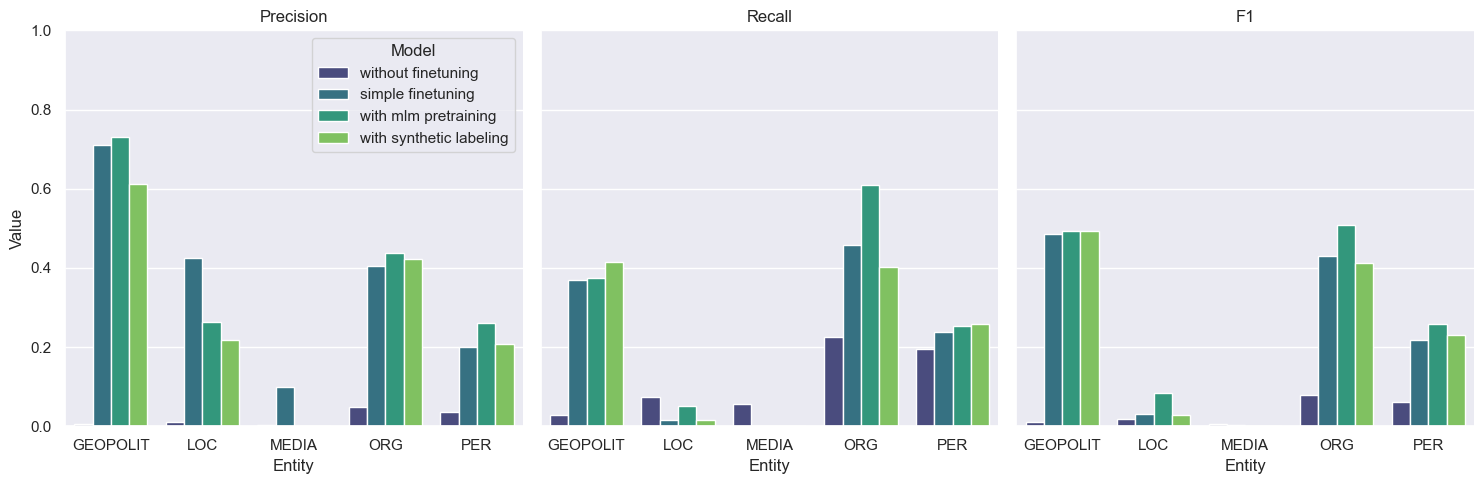

In [ ]:
entity_data = {
    "Model": ["without finetuning"] * 5
    + ["simple finetuning"] * 5
    + ["with mlm pretraining"] * 5
    + ["with synthetic labeling"] * 5,
    "Entity": ["GEOPOLIT", "LOC", "MEDIA", "ORG", "PER"] * 4,
    "Precision": [
        0.0062,
        0.0099,
        0.0034,
        0.0478,
        0.0361,
        0.7111,
        0.4259,
        0.1000,
        0.4036,
        0.2008,
        0.7306,
        0.2637,
        0.0000,
        0.4364,
        0.2597,
        0.6125,
        0.2188,
        0.0000,
        0.4214,
        0.2070,
    ],
    "Recall": [
        0.0279,
        0.0738,
        0.0571,
        0.2255,
        0.1940,
        0.3699,
        0.0160,
        0.0014,
        0.4583,
        0.2382,
        0.3735,
        0.0501,
        0.0000,
        0.6105,
        0.2542,
        0.4140,
        0.0146,
        0.0000,
        0.4033,
        0.2573,
    ],
    "F1": [
        0.0101,
        0.0175,
        0.0064,
        0.0789,
        0.0609,
        0.4867,
        0.0309,
        0.0027,
        0.4292,
        0.2179,
        0.4943,
        0.0843,
        0.0000,
        0.5090,
        0.2569,
        0.4941,
        0.0274,
        0.0000,
        0.4122,
        0.2294,
    ],
}

df_entities = pd.DataFrame(entity_data)

# Переформатируем данные для построения графика
melted = df_entities.melt(
    id_vars=["Model", "Entity"], value_vars=["Precision", "Recall", "F1"], var_name="Metric", value_name="Value"
)

# Устанавливаем стиль графика
sns.set_theme()

# Строим график: для каждой метрики по 4 столбца (по моделям)
chart = sns.catplot(
    data=melted,
    kind="bar",
    x="Entity",
    y="Value",
    hue="Model",
    col="Metric",
    palette="viridis",
    height=5,
    aspect=1,
    legend_out=False,
)

chart.set_titles("{col_name}")
chart.set_axis_labels("Entity", "Value")
chart.set(ylim=(0, 1))
chart._legend.set_title("Model")

**Главные выводы, которые можно сделать из графиков:**
1. Ориентируясь только на Precision и Recall, не получается выделить лучшую модель. По F1 лучшей моделью в каждой категории оказалась модель с предобучением на MLM задачу.
2. У тега MEDIA было наименьшее количество элементов, поэтому почти никакая модель не предсказывала его. 
3. Использование синтетической разметки только усугубило проблему дисбаланса классов, так как было всего 3 из 5 изначальных тегов.
4. Без дообучения модель практически не справляется ни с одной категорией, тк классификационная голова не дообучена и предопределена рандомом. Простое дообучение и особенно MLM pretraining значительно улучшают результаты.
5. Синтетическая разметка даёт переменные результаты — иногда помогает (например, Recall для GEOPOLIT), иногда наоборот ухудшает.